<a href="https://colab.research.google.com/github/SamuelOliveira/Colab/blob/main/FT084_2021S1_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://moodle.ggte.unicamp.br/pluginfile.php/1/core_admin/logocompact/300x300/1615465513/unicamp_transp_20180409.png" align="left" hspace="10px" vspace="0px"></p>

# Tarefa 2: Árvores de Decisão, Naïve Bayes, k-NN e Ensembles


**Enunciado:**

Dados os pacotes de software para classificação de dados identificados na tarefa anterior, pede-se:

* Escolha uma destas ferramentas, que tenha implementações de algoritmos de árvores de decisão, naïve Bayes e k-NN, e aplique estes **três algoritmos** ao conjunto de dados [Liver Disorder](http://goo.gl/QCuYTc):
  - Utilize subamostragem aleatória com 5 repetições para cada algoritmo e apresente o erro de classificação **médio** de cada um (para os conjuntos de testes);
  - Adote uma divisão de 70% dos dados para treinamento e 30% dos dados para teste;
  - Faça a amostragem antes de iniciar o treinamento e use os mesmos dados para todos os algoritmos (em cada repetição);
* Para cada repetição, monte um **ensemble** com os classificadores já treinados (via voto majoritário), aplique ao conjunto de testes e apresente o desempenho médio.

**ATENÇÃO**: Não se esqueça de apresentar no relatório os **parâmetros** definidos para cada algoritmo (caso existam)!

**Formato:**

*   Fonte: Times New Roman ou Calibri;
*   Tamanho da fonte: 12pt;
*   Espaçamento: 1,15;
*   Margens: 2cm;
*   **ATENÇÃO**: seja sucinto e completo.

**Informações Adicionais:**

Entregar o texto em PDF e o **arquivo de dados** no formato da ferramenta escolhida (em um único arquivo .ZIP).

# Importando Bilbiotecas

In [155]:
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image

from sklearn import preprocessing
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss

# DECLARANDO FUNÇÃO PARA PLOTAR A MATRIZ DE CONFUSÃO
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Matriz de Confusão ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Matriz de Confusão Normalizada")
    # else:
    #     print('Matriz de Confusão Desnormalizada')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo Real')
    plt.xlabel('Rótulo Previsto')

# Pre-processamento

* Criando o DataFrame
* Discretizando Cados Continuos
  - atributo **drinks**
* Preparando Amostras
  - 70% Treino
  - 30% Teste

In [156]:
df = pd.read_csv('sample_data/bupa.csv')

name_label = 'drinks_label'
name_features = ['mcv','alkphos','sgpt','sgot','gammagt']

bins = [-1, 2, 5, 20]
df[name_label] = pd.cut(df['drinks'].to_numpy(), bins=bins, labels=['abstêmio', 'socialmente', 'alcoólatra'])

# PREPARANDO O SPLIT DO DATAFRAME 80/20, AMOSTRA ALEATORIA
df_tr = df.sample(frac=0.80)
df_ts = df.sample(frac=0.20)

Y_train, Y_test = df_tr[name_label].values, df_ts[name_label].values
X_train, X_test = df_tr[name_features].values, df_ts[name_features].values

# NORMALIZANDO AMOSTRAS DE TREINO
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ARMAZENANDO AS AMOSTRAS
df_tr.to_csv('sample_data/bupa_train.csv')
df_ts.to_csv('sample_data/bupa_test.csv')

# Árvore de Decisão

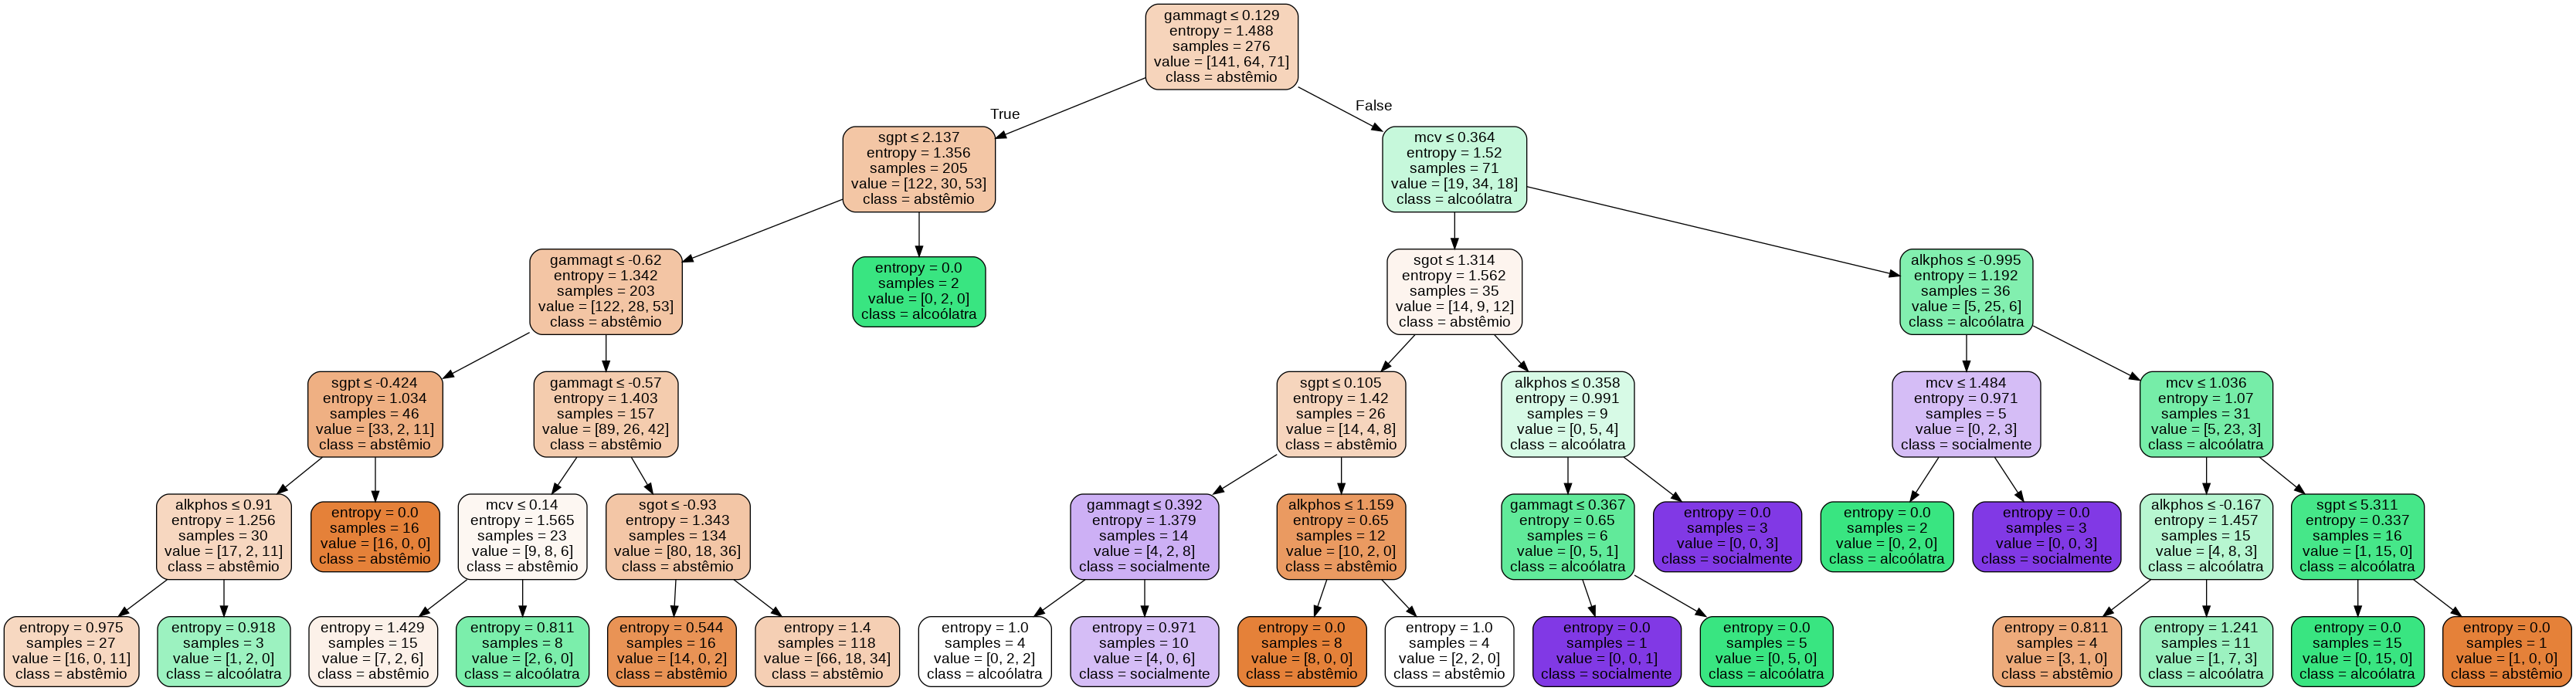

In [157]:
decisionTree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
model_tree = decisionTree.fit(X_train, Y_train)

name_classes = model_tree.classes_

# MONTAR A IMAGEM DA ÁRVORE
dot_data = StringIO()
export_graphviz(model_tree, out_file=dot_data, filled=True, feature_names=name_features, class_names=name_classes, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_png("model_tree.png")
Image('model_tree.png')

# Atributos mais importantes

Features de maior importância para o modelo treinado

Rank dos atributos:


1. feature 4 (0.297130) gammagt
2. feature 2 (0.211729) sgpt
3. feature 0 (0.200966) mcv
4. feature 1 (0.187625) alkphos
5. feature 3 (0.102550) sgot




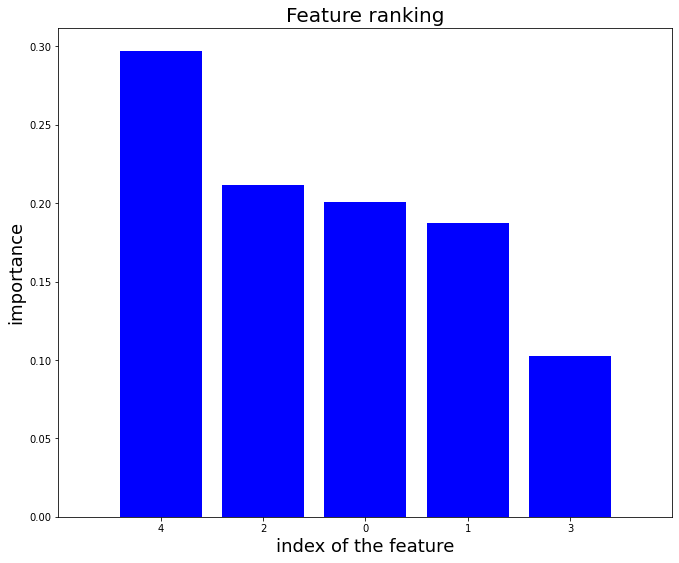

In [158]:
# ARMAZENANDO AS ETIQUETAS EM Y, CLASSES
Y = df[name_label].values

# ARMAZENANDO OS VALORES EM X, FEATURES/ATRIBUTOS
X = df[name_features].values

importances = model_tree.feature_importances_
indices = np.argsort(importances)[::-1]
print("Rank dos atributos:")
print('\n')

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], name_features[indices[f]]))
print('\n')

f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

# Testando Modelo

* Predições;
* Matriz de Confusão.

ACURÁCIA TREE:  69.57%


              precision    recall  f1-score   support

    abstêmio       0.67      0.94      0.78        36
  alcoólatra       0.73      0.73      0.73        15
 socialmente       1.00      0.17      0.29        18

    accuracy                           0.70        69
   macro avg       0.80      0.61      0.60        69
weighted avg       0.77      0.70      0.64        69



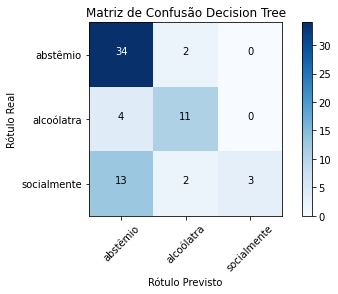

In [159]:
Y_pred_tree = model_tree.predict(X_test)

print("ACURÁCIA TREE: ", "{1:.2f}%".format("", 100 * accuracy_score(Y_test, Y_pred_tree)))
print('\n')
print(classification_report(Y_test, Y_pred_tree))

# precision:  DAS CLASSIFICAÇÕES QUE O MODELO FEZ PARA CADA CLASSE
# recall:     DOS POSSÍVEIS DATAPOINTS PERTECENTES A CADA CLASSE

matrix_confusao = confusion_matrix(Y_test, Y_pred_tree)
plt.figure()
plot_confusion_matrix(matrix_confusao, classes=name_classes, title='Decision Tree')